# Notebook to Investigate LSTM Performance On Test Set B

# Step 0 - Set up Notebook

In [1]:
# import needed libaries
import os
import boto3
import mlflow
import time
from PIL import Image
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings 
from snowML.datapipe import snow_types as st
from snowML.datapipe import get_geos as gg
import os

In [2]:
# ignore future warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# initialize erathengine credentials
import ee
ee.Authenticate(auth_mode='notebook')

True

# Step1 - Get MLFlow Metrics

In [4]:
# Upload Metrics + Snow Class Data created by Notebook "notebooks/Ex3_MultiHucTraining/LSTM_By_Huc_Metric_Download_TestMetrics.ipynb
# These are the metrics for the last epoch (epoch 10) for each huc_id, combined with snow_type data 
f = "TestB__metrics_w_snow_types_and_elev.csv"
df_metrics = pd.read_csv(f)
print(df_metrics.shape)
df_metrics.head(2)

(48, 10)


,huc_id,Name,Test MSE,Test KGE,Test_R2,Predominant_Snow,color_snow_type,mean_elevation,geometry,Elevation Category
0,170300010101,Waptus River,0.011511,0.784917,0.935723,Maritime,yellow,1408.847046,POLYGON ((-121.17832766216678 47.5656403111437...,mid
1,170300010102,Headwaters Cle Elum River,0.018615,0.710050,0.900482,Maritime,yellow,1481.231323,POLYGON ((-121.11591677841595 47.5978030854750...,mid


In [5]:
color_map = {
    "Montane Forest": "orange", 
    "Maritime": "yellow", 
    "Prairie": "red"
}

# Step 2 - Define Plotting Functions 

In [6]:
import matplotlib.pyplot as plt

def plot_scatter(df, x_var_name, y_var_name, color_map, title="Scatter_Plot", save_local=True, show_legend=True):
    """
    Creates a scatter plot of specified x and y variables, colored by Predominant Snow Type.

    Parameters:
    - df: DataFrame containing the x and y variables and "color_snow_type" column.
    - x_var_name: Column name for the x-axis variable.
    - y_var_name: Column name for the y-axis variable.
    - color_map: Dictionary mapping labels to their respective colors for the legend.
    - title: Title of the plot (default: "Scatter Plot" with underscores).
    - save_local: If True, saves the plot as a PNG file.
    - show_legend: If True, shows the legend (default is True).
    """
    plt.figure(figsize=(10, 6))

    # Use colors directly from the dataframe, default to white if missing
    colors = df["color_snow_type"].fillna("white")

    plt.scatter(df[x_var_name], df[y_var_name], c=colors, alpha=0.7, edgecolors="k")

    # Add labels and title
    plt.xlabel(x_var_name.replace("_", " "))
    plt.ylabel(y_var_name.replace("_", " "))
    plt.title(title.replace("_", " "))

    # Show legend if show_legend is True
    if show_legend:
        handles = [plt.Line2D([0], [0], marker='o', color=color, markersize=8, label=label) 
                   for label, color in color_map.items()]
        plt.legend(handles=handles, title="Predominant Snow Type", bbox_to_anchor=(1.05, 0.5), loc='center left')

    # Show or save plot
    if save_local:
        plt.savefig(f"charts/{title}.png", bbox_inches='tight')

    plt.show()




In [7]:
def plot_boxplot_by_group(df, parameter, title, groupby_column, color_map=None, category_order=None, trunc=False, save_local=True):
    """
    Plot a boxplot for the given parameter grouped by a specified column.
    
    Parameters:
    - df: DataFrame containing the data.
    - parameter: The name of the parameter to be plotted (as a column in the DataFrame).
    - title: The title of the plot.
    - groupby_column: The column by which to group the data.
    - color_map: A dictionary mapping categories to colors. Defaults to None.
    - category_order: Optional list of categories in the desired order for plotting.
    - trunc: If True, rotates labels 90 degrees and truncates them to 15 characters.
    - save_local: If True, saves the plot as a PNG file in the 'charts/' directory.
    """
    
    # Define a default color map if none is provided
    if color_map is None:
        default_palette = sns.color_palette("husl", len(df[groupby_column].unique()))
        color_map = dict(zip(sorted(df[groupby_column].unique()), default_palette))

    # If category_order is not provided, use the keys of the color_map in order
    if category_order is None:
        category_order = list(color_map.keys())

    # Create the boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=groupby_column, y=parameter, palette=color_map, order=category_order)

    # Set the title and labels
    plt.title(title)
    plt.xlabel(groupby_column)
    plt.ylabel(parameter)

    # Adjust x-axis labels based on truncation
    if trunc:
        plt.xticks(rotation=90)  # Rotate labels 90 degrees
    else:
        plt.xticks(rotation=0)  # Keep labels horizontal

    # Ensure layout is clean
    plt.tight_layout()

    # Save the plot locally if save_local is True
    if save_local:
        os.makedirs("charts", exist_ok=True)  # Ensure the directory exists
        safe_title = "".join(c if c.isalnum() or c in (" ", "-", "_") else "_" for c in title)  # Remove invalid filename characters
        plt.savefig(f"charts/{safe_title}.png", bbox_inches='tight')

    # Show the plot
    plt.show()








In [8]:

def plot_boxplot_by_2group(df, parameter, title, groupby_column_1, groupby_column_2, color_map=None, category_order=None, trunc=False, save_local=True):
    """
    Plot a boxplot for the given parameter grouped by two specified columns.
    
    Parameters:
    - df: DataFrame containing the data.
    - parameter: The name of the parameter to be plotted (as a column in the DataFrame).
    - title: The title of the plot.
    - groupby_column_1: The first column by which to group the data (determines left-to-right order).
    - groupby_column_2: The second column for creating side-by-side box plots within each group of groupby_column_1.
    - color_map: A dictionary mapping groupby_column_2 categories to colors. Defaults to None.
    - category_order: Optional list of categories in the desired order for plotting groupby_column_1.
    - trunc: If True, rotates labels 90 degrees and truncates them to 15 characters.
    - save_local: If True, saves the plot as a PNG file in the 'charts/' directory.
    """
    
    # Define a default color map if none is provided
    if color_map is None:
        unique_categories = sorted(df[groupby_column_2].unique())
        default_palette = sns.color_palette("husl", len(unique_categories))
        color_map = dict(zip(unique_categories, default_palette))

    # If category_order is not provided, use the sorted unique values from groupby_column_1
    if category_order is None:
        category_order = sorted(df[groupby_column_1].unique())

    # Apply truncation if enabled
    if trunc:
        category_order = [cat[:15] for cat in category_order]

    # Create the boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x=groupby_column_1, y=parameter, hue=groupby_column_2, 
                palette=color_map, order=category_order, dodge=True)

    # Set the title and labels
    plt.title(title)
    plt.xlabel(groupby_column_1)
    plt.ylabel(parameter)

    # Adjust x-axis labels based on truncation
    if trunc:
        plt.xticks(rotation=90)  # Rotate labels 90 degrees
    else:
        plt.xticks(rotation=0)  # Keep labels horizontal

    # Move the legend outside the plot for better visibility
    plt.legend(title=groupby_column_2, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Ensure layout is clean
    plt.tight_layout()

    # Save the plot locally if save_local is True
    if save_local:
        os.makedirs("charts", exist_ok=True)  # Ensure the directory exists
        safe_title = "".join(c if c.isalnum() or c in (" ", "-", "_") else "_" for c in title)  # Remove invalid filename characters
        plt.savefig(f"charts/{safe_title}.png", bbox_inches='tight')

    # Show the plot
    plt.show()



# Step 3 Create ScatterPlots of Evaluation Metrics

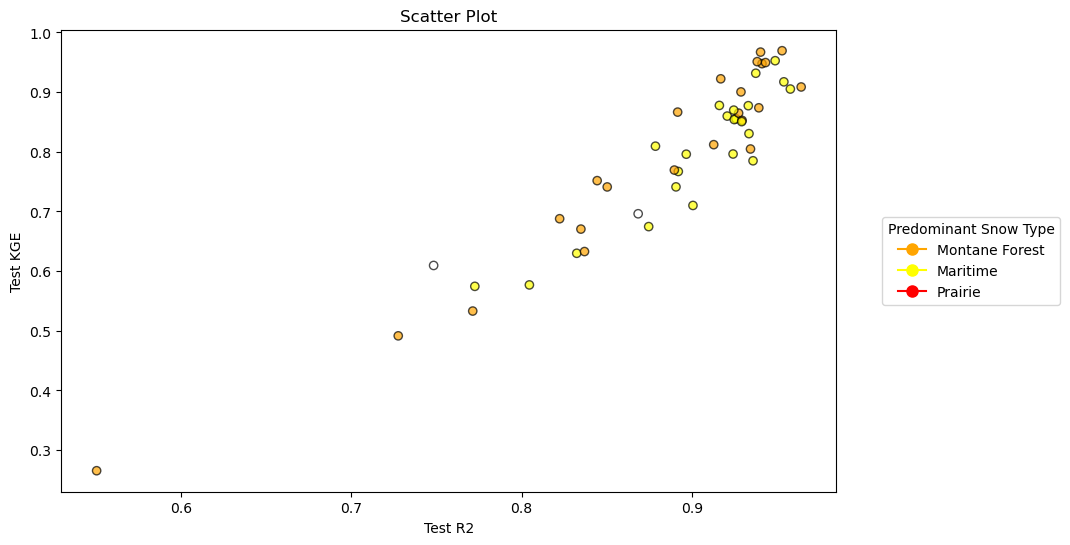

In [9]:
# All results 
plot_scatter(df_metrics, "Test_R2", "Test KGE", color_map, )

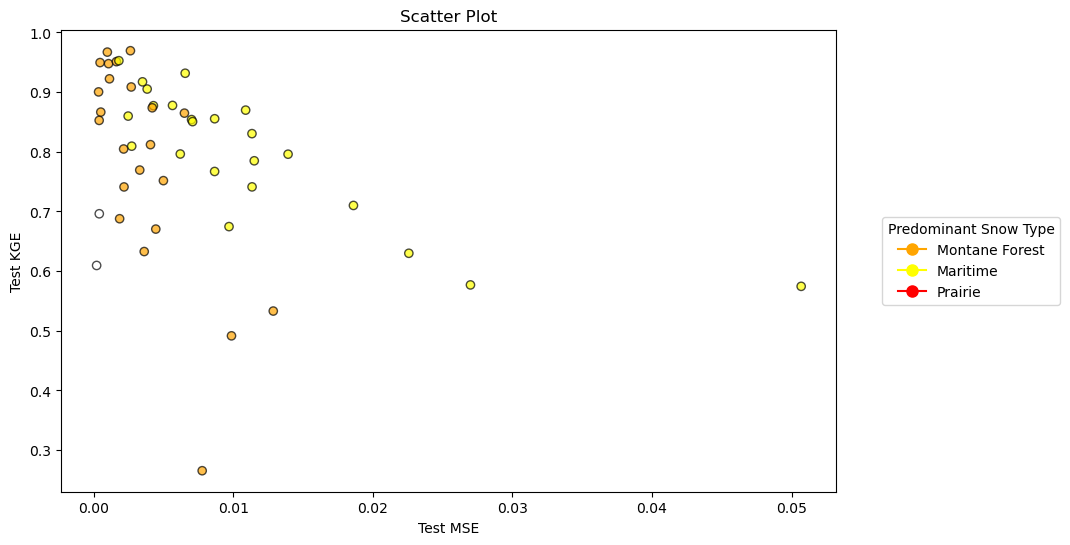

In [10]:
# All results 
plot_scatter(df_metrics, "Test MSE", "Test KGE", color_map, )

# Step 5 - Create box and whisker plot 

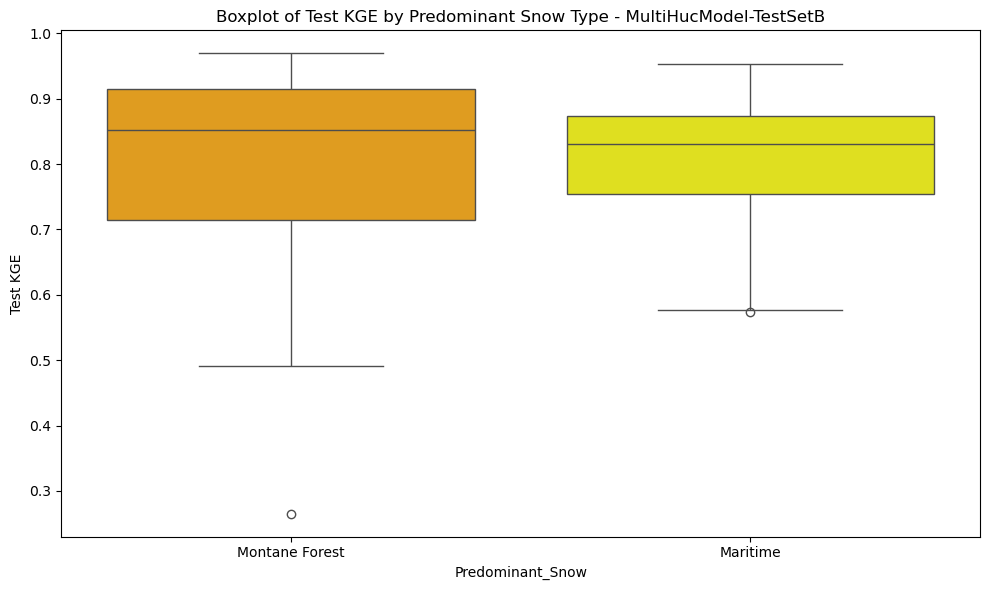

In [11]:
parameter = "Test KGE"
color_map = {"Montane Forest": "orange", "Maritime": "yellow"}
ttl = f"Boxplot of {parameter} by Predominant Snow Type - MultiHucModel-TestSetB"
group_by = "Predominant_Snow"
plot_boxplot_by_group(df_metrics, parameter, title= ttl, groupby_column = group_by, color_map = color_map)


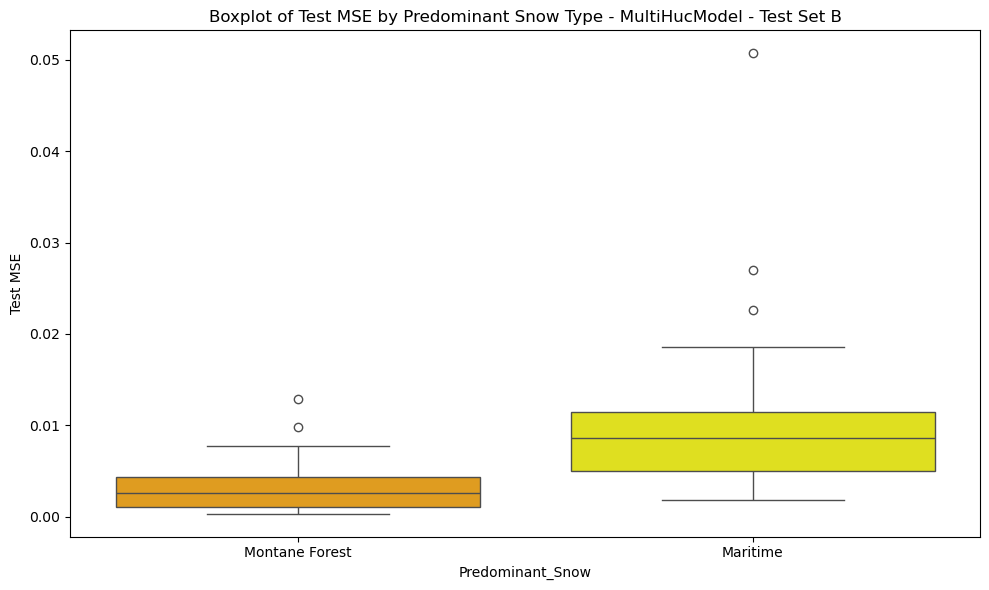

In [12]:
parameter = "Test MSE"
color_map = {"Montane Forest": "orange", "Maritime": "yellow"}
ttl = f"Boxplot of {parameter} by Predominant Snow Type - MultiHucModel - Test Set B"
group_by = "Predominant_Snow"
plot_boxplot_by_group(df_metrics, parameter, title= ttl, groupby_column = group_by, color_map = color_map)

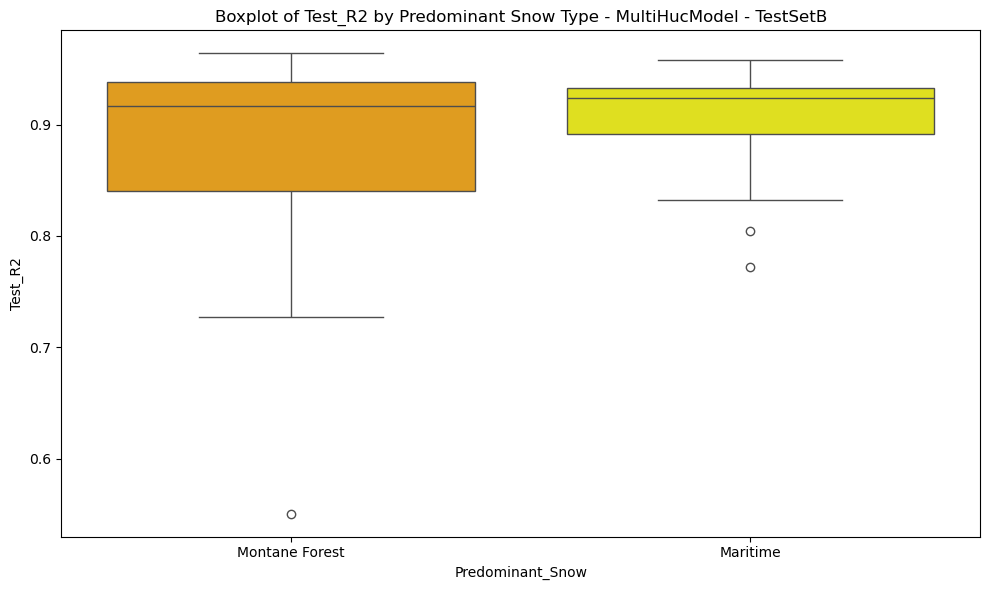

In [13]:

parameter = "Test_R2"
ttl = f"Boxplot of {parameter} by Predominant Snow Type - MultiHucModel - TestSetB"
color_map = {"Montane Forest": "orange", "Maritime": "yellow"}
group_by = "Predominant_Snow"
plot_boxplot_by_group(df_metrics, parameter, title= ttl, groupby_column = group_by, color_map = color_map)

# Step 6 Examine by Elevation 

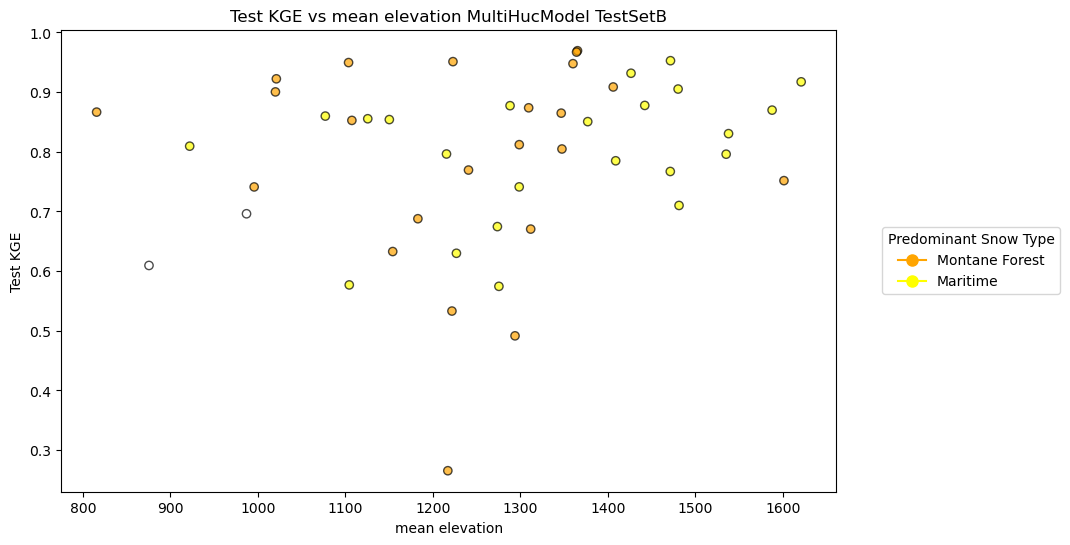

In [14]:
x_var_name = "mean_elevation"
y_var_name = "Test KGE"
ttl = f"{y_var_name}_vs_{x_var_name}_MultiHucModel_TestSetB"
plot_scatter(df_metrics, x_var_name, y_var_name, color_map, title = ttl)

In [15]:
# Count occurrences of each elevation category
elevation_counts = df_metrics['Elevation Category'].value_counts()

# Print the counts
print(elevation_counts)
print(np.sum(elevation_counts))

Elevation Category
mid          38
lower mid     5
upper mid     5
Name: count, dtype: int64
48


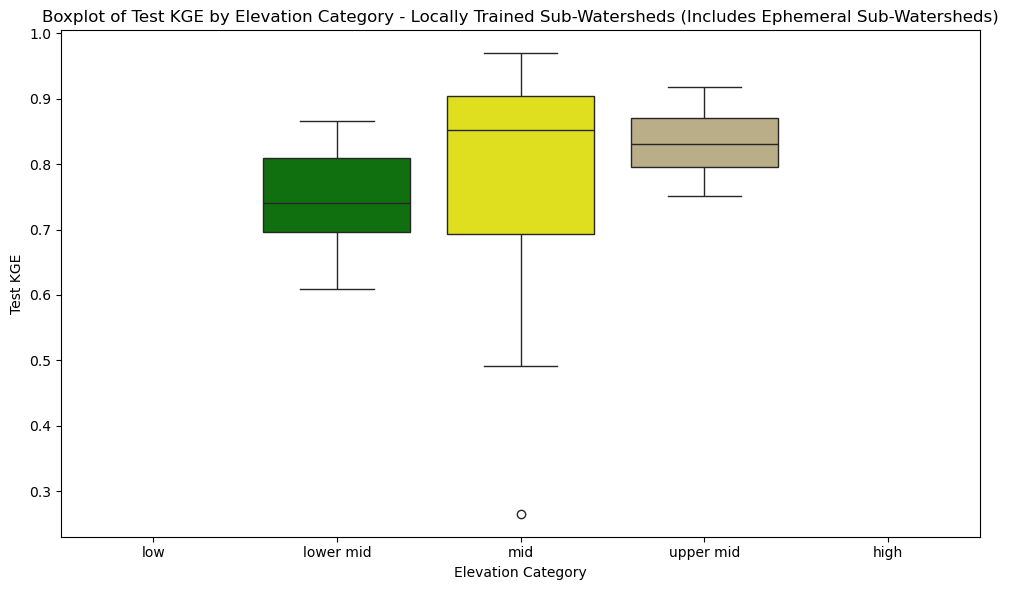

In [16]:
parameter = "Test KGE"
groupby ="Elevation Category"
ttl = f"Boxplot of {parameter} by {groupby} - Locally Trained Sub-Watersheds (Includes Ephemeral Sub-Watersheds)"
color_map = {"low": "blue", "lower mid": "green", "mid": "yellow", "upper mid": "#C2B280", "high": "#A52A2A"}
plot_boxplot_by_group(df_metrics, parameter, title= ttl, groupby_column = groupby, color_map = color_map)

In [17]:
#parameter = "Test MSE"
#groupby ="Elevation Category"
#ttl = f"Boxplot of {parameter} by {groupby} - Locally Trained Sub-Watersheds (Includes Ephemeral Sub-Watersheds)"
#color_map = {"low": "blue", "lower mid": "green", "mid": "yellow", "upper mid": "#C2B280", "high": "#A52A2A"}
#plot_boxplot_by_group(filtered_df, parameter, title= ttl, groupby_column = groupby, color_map = color_map)

In [ ]:
# Step 7 - Select Examples with Range of Test KGE Values 

In [25]:
def extract_percentile_rows(df, column="Test KGE"):
    percentiles = [0.1, 0.5, 0.9]  # 10th, median (50th), and 90th percentiles
    percentile_values = df[column].quantile(percentiles)  # Compute percentiles

    # Find the rows closest to the percentile values
    closest_rows = df.loc[df[column].apply(lambda x: (percentile_values - x).abs()).idxmin()]
    
    return closest_rows




In [26]:
df_selected = extract_percentile_rows(df_metrics, column="Test KGE")
df_selected

,huc_id,Name,Test MSE,Test KGE,Test_R2,Predominant_Snow,color_snow_type,mean_elevation,geometry,Elevation Category
24,170300010701,Umtanum Creek,0.000222,0.609467,0.748348,Prairie,white,875.559692,POLYGON ((-120.52225569500297 46.9019692650443...,lower mid
30,170300020106,Upper American River,0.011347,0.830431,0.933349,Maritime,yellow,1537.794434,POLYGON ((-121.36243840126095 46.9612511121467...,upper mid
15,170300010402,High Creek-Naneum Creek,0.001076,0.947728,0.940983,Montane Forest,orange,1360.045288,POLYGON ((-120.40603725970101 47.2737804992776...,mid


# Step Last Examine Outliers

In [18]:
# extract the five rows with highest MSE - what do they have in common? 
largest_mse = (df_metrics.nlargest(5, "Test MSE"))
print(largest_mse)

          huc_id                       Name  Test MSE  Test KGE   Test_R2  \
2   170300010103               Cooper River  0.050682  0.574467  0.772520   
12  170300010303              Kachess River  0.026996  0.576855  0.804523   
13  170300010305                  Big Creek  0.022582  0.629888  0.832311   
1   170300010102  Headwaters Cle Elum River  0.018615  0.710050  0.900482   
28  170300020104                 Deep Creek  0.013933  0.795983  0.896554   

   Predominant_Snow color_snow_type  mean_elevation  \
2          Maritime          yellow     1275.402710   
12         Maritime          yellow     1104.406250   
13         Maritime          yellow     1226.841553   
1          Maritime          yellow     1481.231323   
28         Maritime          yellow     1535.074585   

                                             geometry Elevation Category  
2   POLYGON ((-121.26839402957458 47.5235067805779...                mid  
12  POLYGON ((-121.19034663403964 47.3866340706936...   

In [19]:
for huc_id in largest_mse["huc_id"]:
    geos = gg.get_geos_with_name(huc_id, '12')
    #print(geos)
    largest_mse.loc[largest_mse["huc_id"] == huc_id, "Name"] = geos.iloc[0]["name"]
    largest_mse.loc[largest_mse["huc_id"] == huc_id, "geometry"] = geos.iloc[0]["geometry"]
largest_mse_gdf = gpd.GeoDataFrame(largest_mse, geometry="geometry")
largest_mse_gdf.set_crs("EPSG:4326", inplace=True) 

largest_mse_gdf

,huc_id,Name,Test MSE,Test KGE,Test_R2,Predominant_Snow,color_snow_type,mean_elevation,geometry,Elevation Category
2,170300010103,Cooper River,0.050682,0.574467,0.772520,Maritime,yellow,1275.402710,"POLYGON ((-121.26839 47.52351, -121.26846 47.5...",mid
12,170300010303,Kachess River,0.026996,0.576855,0.804523,Maritime,yellow,1104.406250,"POLYGON ((-121.19035 47.38663, -121.19027 47.3...",mid
13,170300010305,Big Creek,0.022582,0.629888,0.832311,Maritime,yellow,1226.841553,"POLYGON ((-121.1602 47.11507, -121.16026 47.11...",mid
1,170300010102,Headwaters Cle Elum River,0.018615,0.710050,0.900482,Maritime,yellow,1481.231323,"POLYGON ((-121.11592 47.5978, -121.11602 47.59...",mid
28,170300020104,Deep Creek,0.013933,0.795983,0.896554,Maritime,yellow,1535.074585,"POLYGON ((-121.27937 46.82528, -121.27966 46.8...",upper mid


In [20]:
largest_mse_gdf.explore()